In [24]:
import scipy.sparse as sps
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
from Evaluation.Evaluator import EvaluatorHoldout
from Data_Handler.DataReader import DataReader
import scipy.sparse as sps
from collections import Counter
from tqdm import tqdm
# imports for .env usage
import os
from dotenv import load_dotenv
load_dotenv()



True

In [25]:
from Data_Handler.DataReader import DataReader 
dataReader=DataReader()
urm=dataReader.load_augmented_binary_urm()
powerful_urm=dataReader.load_powerful_binary_urm()

URM_train, URM_validation = split_train_in_two_percentage_global_sample(urm, train_percentage = 0.9)
train_powerful, val_powerful = split_train_in_two_percentage_global_sample(powerful_urm, train_percentage = 0.9)
#train_pad, val_pad = split_train_in_two_percentage_global_sample(urm_pad, train_percentage = 0.9)

In [26]:
profile_length = np.ediff1d(sps.csr_matrix(URM_train).indptr)
profile_length, profile_length.shape

(array([60, 18, 89, ..., 19, 49, 19], dtype=int32), (41629,))

In [27]:
block_size = int(len(profile_length)*0.1)
block_size

4162

In [28]:
sorted_users = np.argsort(profile_length)
sorted_users

array([ 4769, 25061, 39253, ..., 19407,  8693, 12454])

In [29]:
for group_id in range(0, 10):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

Group 0, #users in group 4162, average p.len 12.86, median 13.0, min 3, max 15
Group 1, #users in group 4162, average p.len 16.66, median 17.0, min 15, max 18
Group 2, #users in group 4162, average p.len 19.14, median 19.0, min 18, max 20
Group 3, #users in group 4162, average p.len 21.64, median 22.0, min 20, max 23
Group 4, #users in group 4162, average p.len 24.27, median 24.0, min 23, max 26
Group 5, #users in group 4162, average p.len 27.49, median 27.0, min 26, max 29
Group 6, #users in group 4162, average p.len 31.82, median 32.0, min 29, max 35
Group 7, #users in group 4162, average p.len 38.34, median 38.0, min 35, max 43
Group 8, #users in group 4162, average p.len 49.56, median 49.0, min 43, max 59
Group 9, #users in group 4162, average p.len 92.81, median 77.0, min 59, max 508


In [30]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython, MatrixFactorization_FunkSVD_Cython, MatrixFactorization_AsySVD_Cython
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import ItemKNN_CFCBF_Hybrid_Recommender
from Recommenders.FactorizationMachines.LightFMRecommender import LightFMItemHybridRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {
        "SLIMElasticNetRecommender": SLIMElasticNetRecommender,
        "UserKNNCF": UserKNNCFRecommender,
        "ItemKNNCF": ItemKNNCFRecommender,
        "RP3beta": RP3betaRecommender,
        "TopPop": TopPop,
}

recommender_object_dict = {}
recommended_items_for_each_user = {}

for label, recommender_class in collaborative_recommender_class.items():
    if(label == "SLIMElasticNetRecommender"):
        recommender_object = recommender_class(train_powerful)
        recommender_object.fit()
    else:
        recommender_object = recommender_class(URM_train)
        recommender_object.fit()
    recommender_object_dict[label] = recommender_object


SLIMElasticNetRecommender: URM Detected 356 ( 1.3%) items with no interactions.
SLIMElasticNetRecommender: Processed 6625 (23.7%) in 5.00 min. Items per second: 22.08
SLIMElasticNetRecommender: Processed 13611 (48.7%) in 10.00 min. Items per second: 22.68
SLIMElasticNetRecommender: Processed 21534 (77.0%) in 15.00 min. Items per second: 23.92
SLIMElasticNetRecommender: Processed 27968 (100.0%) in 19.44 min. Items per second: 23.97
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 41629 (100.0%), 780.09 column/sec. Elapsed time 53.36 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 869.37 column/sec. Elapsed time 28.19 sec
RP3betaRecommender: Similarity column 24507 (100.0%), 2216.92 column/sec. Elapsed time 11.05 sec


In [31]:
evaluator=EvaluatorHoldout(URM_validation, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2913 ( 7.0%) Users that have less than 1 test interactions


In [32]:
from evaluator import evaluate
cutoff = 10

for group_id in range(0, 10):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_validation, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    evaluator_power = EvaluatorHoldout(val_powerful, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    #evaluator_pad = EvaluatorHoldout(val_pad, cutoff_list=[cutoff], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        if(label == "SLIMElasticNetRecommender"):
            #map=evaluate(recommended_items_for_each_user,val_powerful,target)
            result_df, _ = evaluator_power.evaluateRecommender(recommender)
        
        else:
            #map=evaluate(recommended_items_for_each_user,URM_validation,target)
            result_df, _ = evaluator_test.evaluateRecommender(recommender)
            
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
            #MAP_recommender_per_group[label].append(map)
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]
            #MAP_recommender_per_group[label] = [map]


Group 0, #users in group 4162, average p.len 12.86, median 13.0, min 3, max 15
EvaluatorHoldout: Ignoring 2913 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 37467 Users
EvaluatorHoldout: Ignoring 2881 ( 6.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 37467 Users
EvaluatorHoldout: Processed 3296 (100.0%) in 1.94 sec. Users per second: 1697
EvaluatorHoldout: Processed 3603 (100.0%) in 2.30 sec. Users per second: 1569
EvaluatorHoldout: Processed 3603 (100.0%) in 2.50 sec. Users per second: 1444
EvaluatorHoldout: Processed 3603 (100.0%) in 1.68 sec. Users per second: 2145
EvaluatorHoldout: Processed 3603 (100.0%) in 1.76 sec. Users per second: 2051
Group 1, #users in group 4162, average p.len 16.66, median 17.0, min 15, max 18
EvaluatorHoldout: Ignoring 2913 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 37467 Users
EvaluatorHoldout: Ignoring 2881 ( 6.9%) Users that have less than 1 test int

10
10
10
10
10


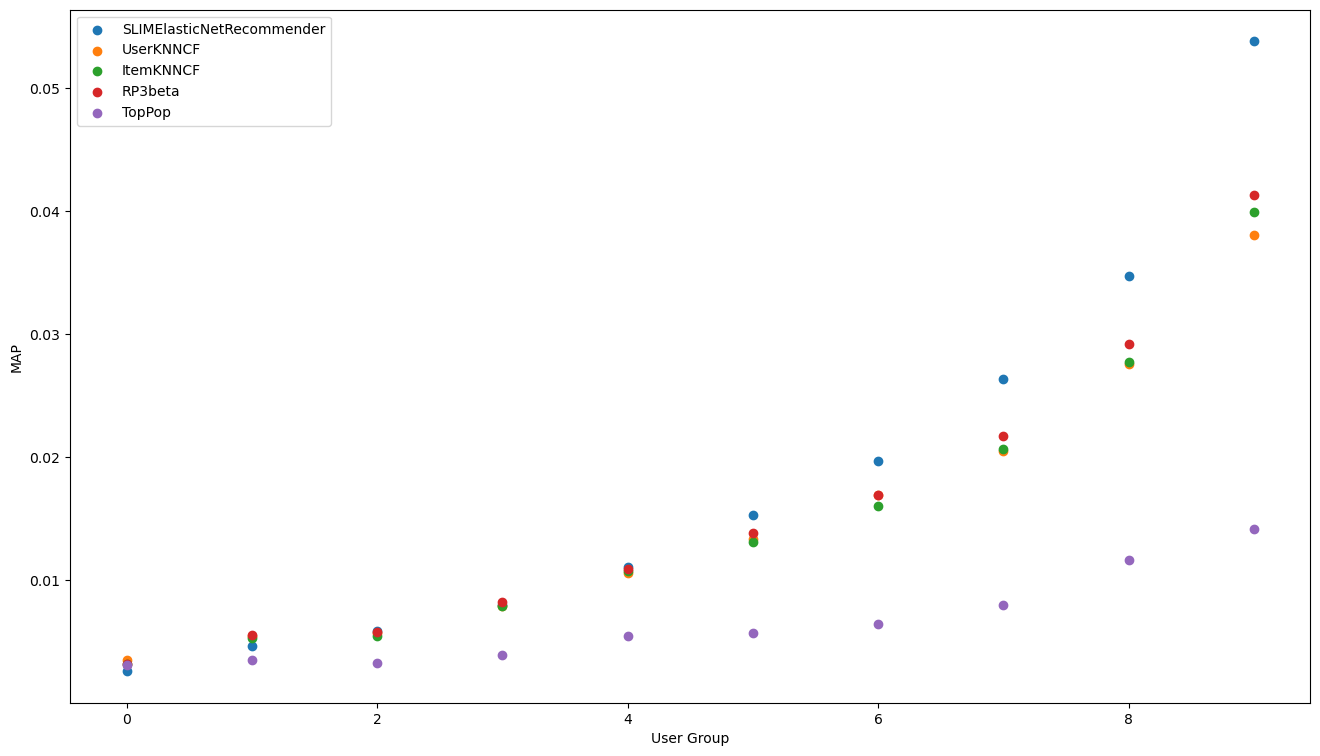

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
    print(len(results))
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()